# Embeddings Analysis 

This notebook is designated for manual analysis in case the python scripts behave not as intended.



In [1]:
import os
import pickle
import torch
from tqdm import tqdm

from utils import find_files_with_key_words  # Assuming this function is defined in a module named 'utils'
import torch.nn as nn

## 1. Some error in latent encoding function

Training Objects

In [2]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=20, dropout=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

class MoralClassifier(nn.Module):
    """A classifier that can inject character information into BERT embeddings."""

    def __init__(self, base_model, latent_dim=768, inject_operation = "summation"):
        super().__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)  # Binary classification (moral or not)
        self.operation = inject_operation

    def forward(self, input_ids, attention_mask, char_vec=None):
        """
        A forward function. This can be extended to support more operations.
        """

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        if char_vec is not None:
            if self.operation == "summation":
                cls_embedding = cls_embedding + char_vec  # Inject character info

        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        return logits

In [3]:
target_folder = "../../data/moral-classification/summer-report-5/trial_5/bert"

In [4]:
# Load the embeddings from a file
with open(os.path.join(target_folder, "embeddings.pkl"), "rb") as f:
    embeddings = pickle.load(f)

print("Embeddings recomputed and saved.")

Embeddings recomputed and saved.


In [5]:
def encode_latent_embeddings(embeddings, model_H):
    """Encode the averaged character embeddings using the AutoEncoder model."""
    if not isinstance(embeddings, dict):
        raise ValueError("Embeddings should be a dictionary with movie and character keys.")

    encoded_embeddings = {}
    device = next(model_H.parameters()).device  # Ensure tensor is on correct device

    for movie, characters in tqdm(embeddings.items(), desc="Encoding movies"):
        encoded_embeddings[movie] = {}
        for character, sentence_embeddings in tqdm(characters.items(), desc=f"Encoding characters in {movie}", leave=False):
            if len(sentence_embeddings) == 0:  # handle empty list
                print(f"⚠️ No embeddings for {character} in {movie}. Skipping.")
                continue
            sentence_tensor = torch.tensor(sentence_embeddings).float().to(device)  # shape: [N, 768]
            avg_embedding = sentence_tensor.mean(dim=0).unsqueeze(0)               # shape: [1, 768]
            with torch.no_grad():
                _, encoded = model_H(avg_embedding)
            encoded_embeddings[movie][character] = encoded.squeeze().cpu().numpy()  # shape: [latent_dim]

    return encoded_embeddings

In [6]:
# Load the AutoEncoder model (model_H) from the embeddings_path
ae_path = find_files_with_key_words(target_folder, "model_H")

if ae_path is None:
    raise FileNotFoundError("AutoEncoder model not found in the specified path.")

model_H = Autoencoder()
model_H.load_state_dict(torch.load(ae_path, map_location="cpu"))
model_H.eval()
model_H.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
latent_embeddings = encode_latent_embeddings(embeddings, model_H)

# Save the embeddings to a file
with open(os.path.join(target_folder, "latent_embeddings.pkl"), "wb") as f:
    pickle.dump(latent_embeddings, f)

print("Latent embeddings computed and saved.")

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_89508/3497060960.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_H.load_state_dict(torch.load(ae_path, m

Latent embeddings computed and saved.


Filtered result saved to ../data/moral-classification/filtered_result_bert_1.csv


Filtered result saved to ../data/moral-classification/filtered_result_bert_2.csv


[('latent_2', 'trait_81', np.float64(-0.35949086126449603)),
 ('latent_4', 'trait_81', np.float64(0.3789768384483171)),
 ('latent_6', 'trait_81', np.float64(0.4342080423203572)),
 ('latent_6', 'trait_84', np.float64(-0.37298809429846086)),
 ('latent_7', 'trait_81', np.float64(-0.38731741597186375)),
 ('latent_7', 'trait_84', np.float64(0.380447191183222)),
 ('latent_8', 'trait_84', np.float64(-0.3138354979431927)),
 ('latent_12', 'trait_31', np.float64(0.31589793535854244)),
 ('latent_12', 'trait_396', np.float64(-0.3150736096955118)),
 ('latent_12', 'trait_434', np.float64(0.3672345815536071)),
 ('latent_13', 'trait_81', np.float64(0.3436387395254661)),
 ('latent_13', 'trait_84', np.float64(-0.3122986062621325)),
 ('latent_13', 'trait_434', np.float64(-0.3179539698561034)),
 ('latent_14', 'trait_81', np.float64(-0.32104499576970685)),
 ('latent_15', 'trait_25', np.float64(0.3163680213258291)),
 ('latent_15', 'trait_31', np.float64(0.3634131510074609)),
 ('latent_15', 'trait_81', np.fl

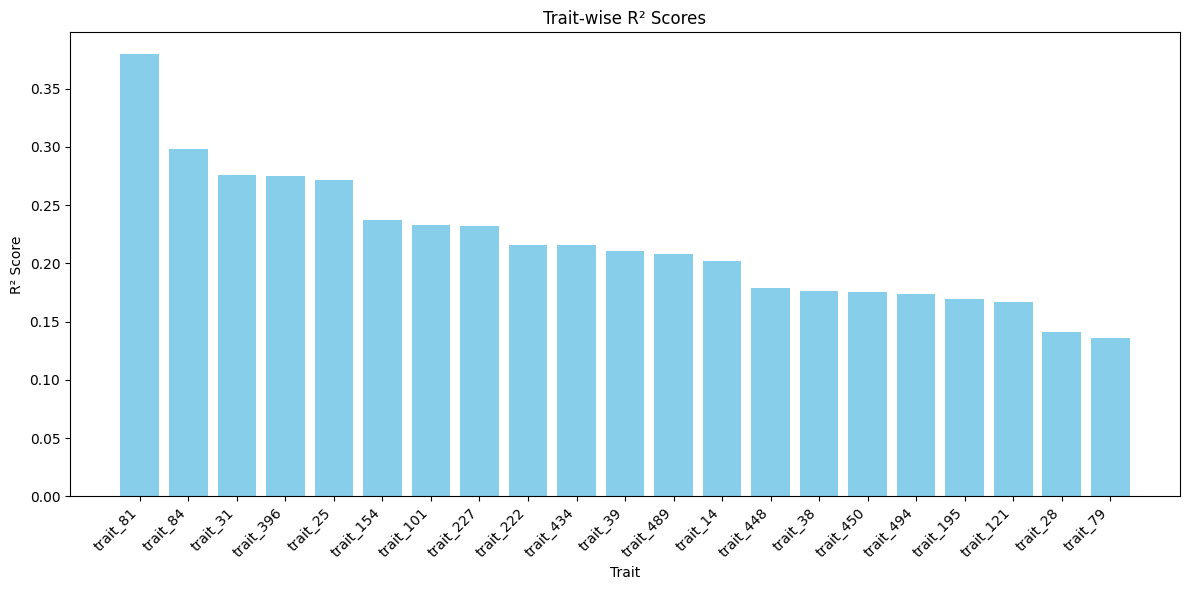